# Análise exploratória inicial dos dados de Expectativa de Vida

Equipe: Avelar Hostalácio, Carolina Brandão, Daniel Andrade, Enzo Pierazolli, Iago Gabino

Dataset utilizado para análises: [Life Expectancy WHO](https://www.kaggle.com/datasets/lashagoch/life-expectancy-who-updated)

## Leitura inicial do dataset e correção de colunas

Substituindo a coluna Economy_status_Developed para 'developed' booleana:

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss

dataset = pd.read_csv('Life-Expectancy-Data.csv')

dataset.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


Contando linhas e colunas:

In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      2864 non-null   object 
 1   Region                       2864 non-null   object 
 2   Year                         2864 non-null   int64  
 3   Infant_deaths                2864 non-null   float64
 4   Under_five_deaths            2864 non-null   float64
 5   Adult_mortality              2864 non-null   float64
 6   Alcohol_consumption          2864 non-null   float64
 7   Hepatitis_B                  2864 non-null   int64  
 8   Measles                      2864 non-null   int64  
 9   BMI                          2864 non-null   float64
 10  Polio                        2864 non-null   int64  
 11  Diphtheria                   2864 non-null   int64  
 12  Incidents_HIV                2864 non-null   float64
 13  GDP_per_capita    

## Reorganizando os dados do banco de dados

Dropamos algumas colunas que consideramos irrelevantes pro projeto e renomeamos outras, para facilitar a visualização/manipulação posterior dos dados.

In [64]:
dataset.drop(['Thinness_ten_nineteen_years', 'Thinness_five_nine_years', 'Economy_status_Developing'], axis=1, inplace=True)

In [65]:
##trocas developing e developed por true e false
dataset.rename(columns={'Economy_status_Developed':'developed'}, inplace=True)
dataset["developed"] = dataset["developed"].astype(bool)
dataset['developed'].unique()

array([False,  True])

In [66]:
# renomear colunas com nomes com letra minuscula e no formato nome_da_coluna
dataset.rename(columns={'Country':'country', 'Region':'region', 'Year':'year', 'Infant_deaths':'infant_deaths', 'Under_five_deaths':'under_five_deaths', 'Adult_mortality':'adult_mortality', 'Alcohol_consumption':'alcohol_consumption', 'Hepatitis_B':'hepatitis_b', 'Measles':'measles', 'BMI':'bmi', 'Polio':'polio', 'Diphtheria':'diphtheria', 'Incidents_HIV':'incidents_hiv', 'GDP_per_capita':'gdp_per_capita', 'Population_mln':'population_mln', 'Schooling':'schooling', 'Life_expectancy':'life_expectancy'}, inplace=True)

In [67]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              2864 non-null   object 
 1   region               2864 non-null   object 
 2   year                 2864 non-null   int64  
 3   infant_deaths        2864 non-null   float64
 4   under_five_deaths    2864 non-null   float64
 5   adult_mortality      2864 non-null   float64
 6   alcohol_consumption  2864 non-null   float64
 7   hepatitis_b          2864 non-null   int64  
 8   measles              2864 non-null   int64  
 9   bmi                  2864 non-null   float64
 10  polio                2864 non-null   int64  
 11  diphtheria           2864 non-null   int64  
 12  incidents_hiv        2864 non-null   float64
 13  gdp_per_capita       2864 non-null   int64  
 14  population_mln       2864 non-null   float64
 15  schooling            2864 non-null   f

## Plots para análise inicial de dados

<Axes: xlabel='year', ylabel='life_expectancy'>

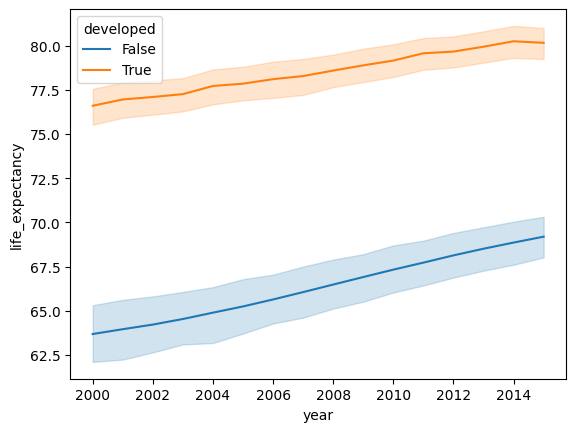

In [68]:
sns.lineplot(x = "year", y = "life_expectancy", hue = "developed", data = dataset)

<Axes: xlabel='year', ylabel='life_expectancy'>

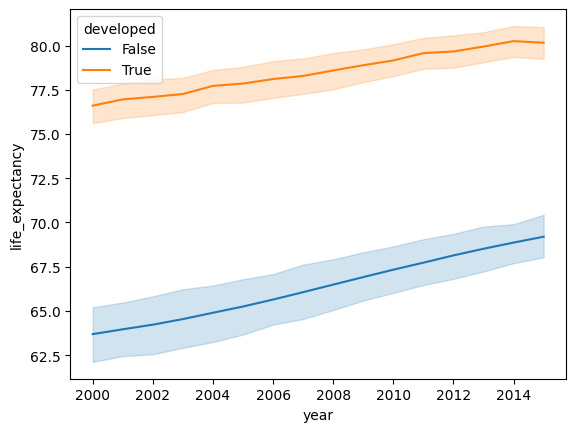

In [69]:
sns.lineplot(x = "year", y = "life_expectancy", hue = "developed", data = dataset)

<Axes: xlabel='year', ylabel='life_expectancy'>

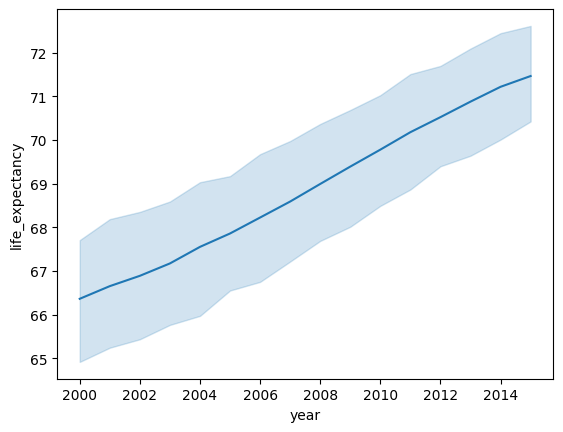

In [70]:
sns.lineplot(x = "year", y = "life_expectancy", data = dataset)

<Axes: xlabel='gdp_per_capita', ylabel='life_expectancy'>

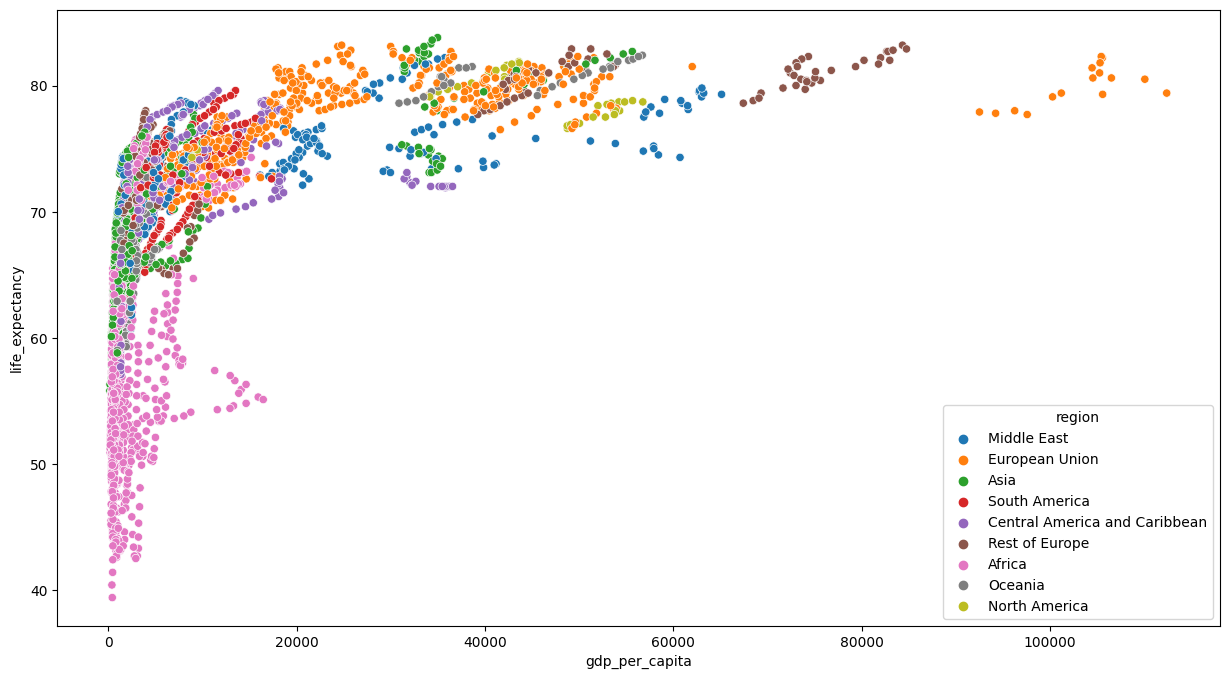

In [71]:
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x="gdp_per_capita", y="life_expectancy",hue="region", data= dataset)

<Axes: xlabel='life_expectancy', ylabel='Count'>

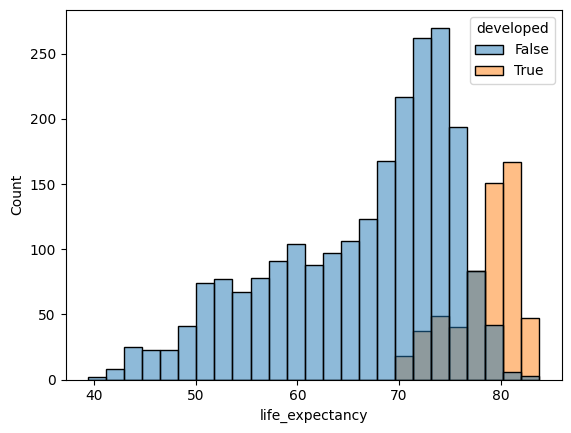

In [72]:
#plot an histogram
sns.histplot(x='life_expectancy', hue='developed', data=dataset)

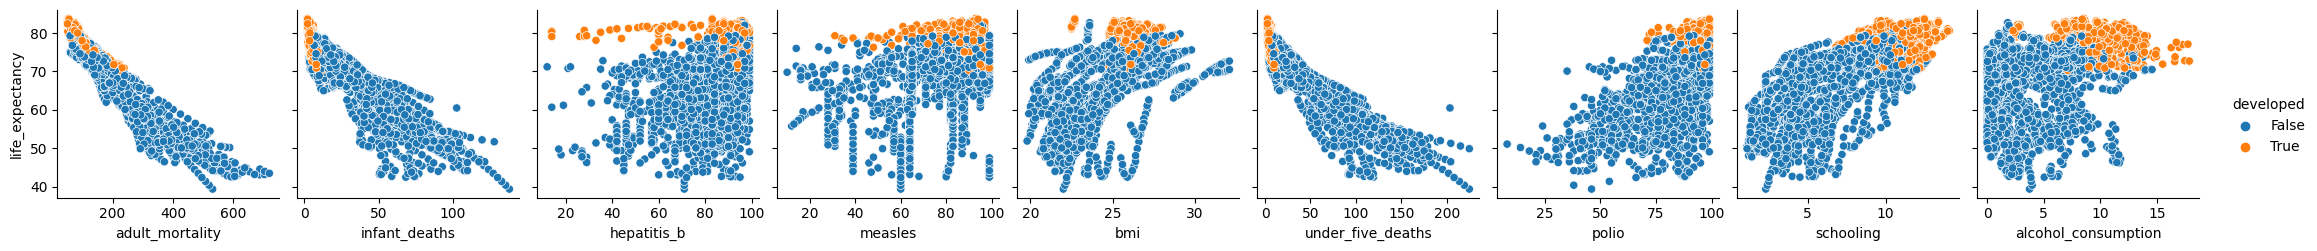

In [73]:
sns.pairplot(dataset, hue='developed', y_vars='life_expectancy', x_vars=['adult_mortality', 'infant_deaths', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'schooling', 'alcohol_consumption'])


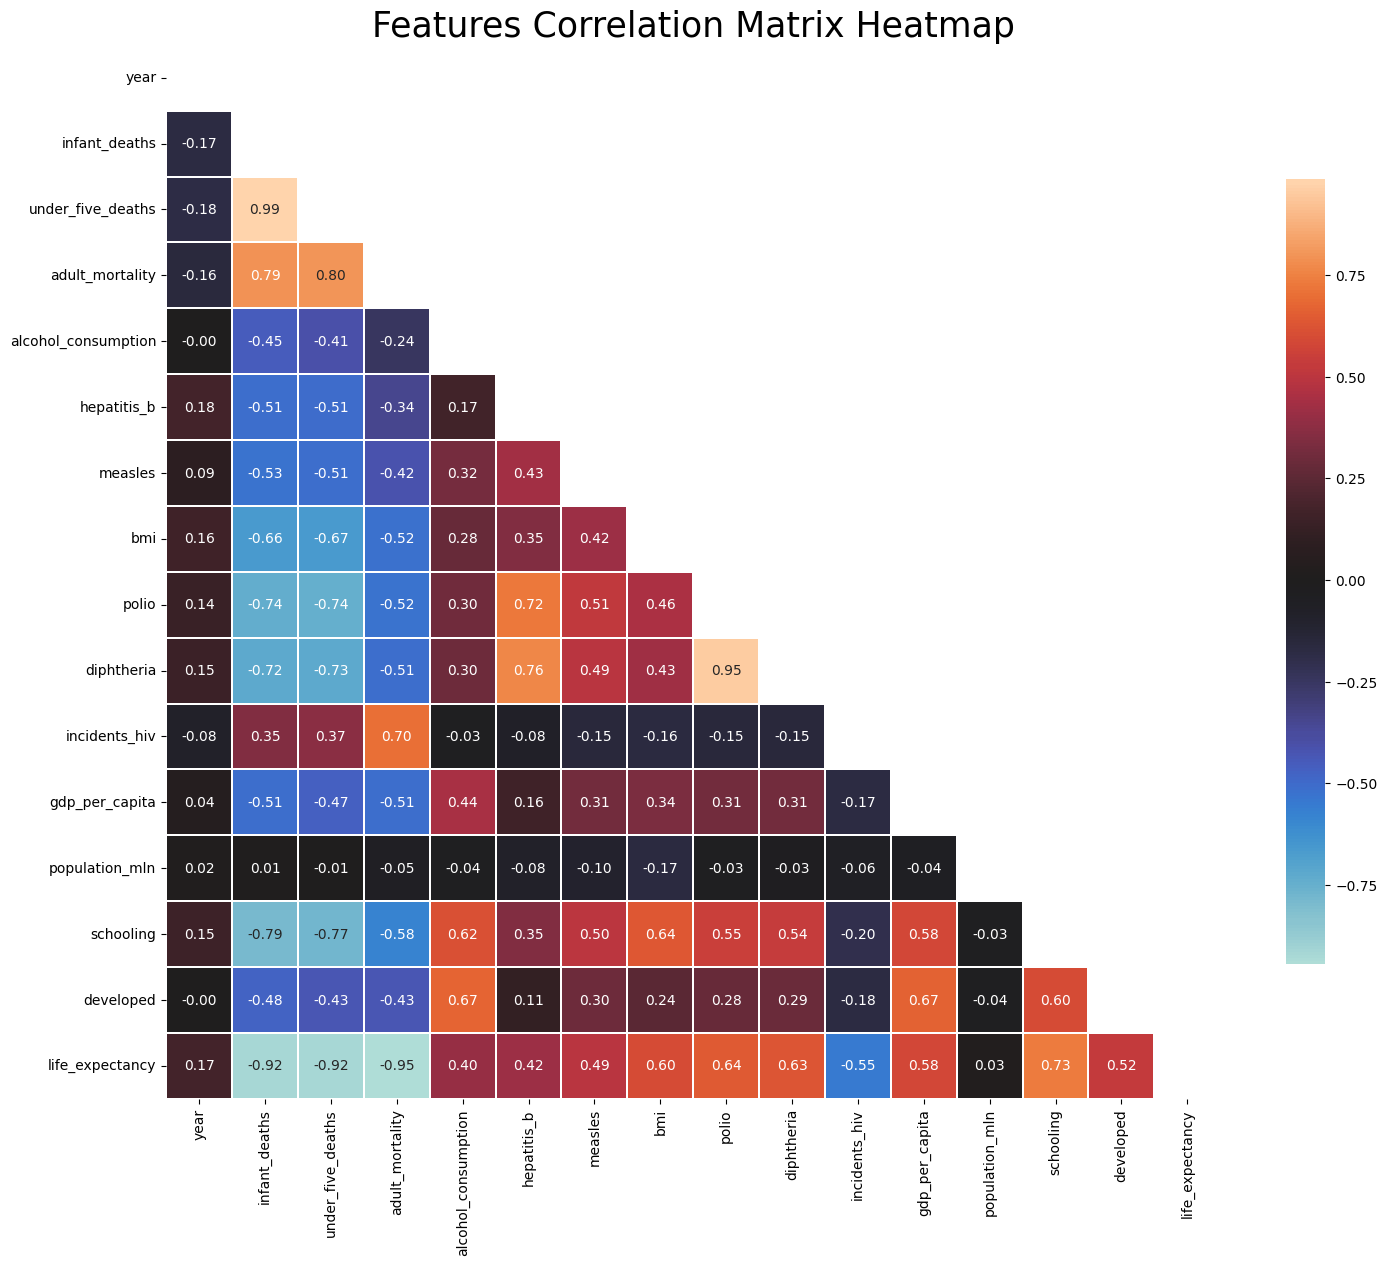

In [74]:
plt.figure(figsize=(17,17))

corr = dataset.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(dataset.corr(numeric_only=True), 
            mask=mask,
            center=0,
            annot=True,
            fmt='.2f',
            square=True,
            linewidths=.2,
            cbar_kws={"shrink": .6})

plt.title('Features Correlation Matrix Heatmap', fontsize=25);

## Consumo de Álcool e a Expectativa de Vida: Europa e África

A partir da EDA, observamos uma moderada correlação entre consumo de álcool e a expectativa de vida. Pensamos que uma maneira interessante de analisar essa correlação seria analisando as duas variáveis na União Europeia e na África, já que são continentes com realidades econômicas e sociais diferentes.

<Axes: xlabel='alcohol_consumption', ylabel='life_expectancy'>

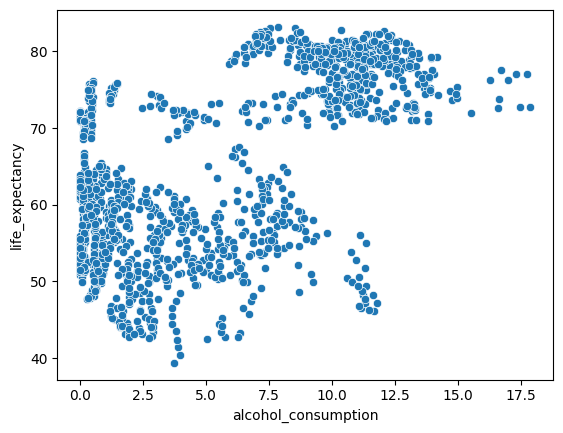

In [75]:
europe_or_africa = dataset[(dataset['region'] == 'European Union') | (dataset['region'] == 'Africa')]

sns.scatterplot(x='alcohol_consumption', y='life_expectancy', data=europe_or_africa)


Calculando a correlação entre as duas variáveis nesses continentes:

In [76]:
from scipy import stats

# calcula a correlação entre as variáveis
pearson_coef, p_value = stats.pearsonr(europe_or_africa['alcohol_consumption'], europe_or_africa['life_expectancy'])
print("Correlação de Pearson: ", pearson_coef, "\nP-valor: ", p_value)

Correlação de Pearson:  0.5993071156171342 
P-valor:  1.503232239552153e-122


Dado que a Correlação de Pearson entre as duas variáveis é aproximadamente 0.6, podemos dizer que há uma correlação positiva considerável. Além disso, um p-valor próximo de 0 indica que a correlação é estatisticamente significativa.

Porém esse resultado não parece condizer com a realidade, dado que o aumento do consumo de álcool não parece ser um fator que aumenta a expectativa de vida. Para entender melhor essa correlação, vamos analisar os dados de cada continente separadamente.

<Axes: xlabel='alcohol_consumption', ylabel='life_expectancy'>

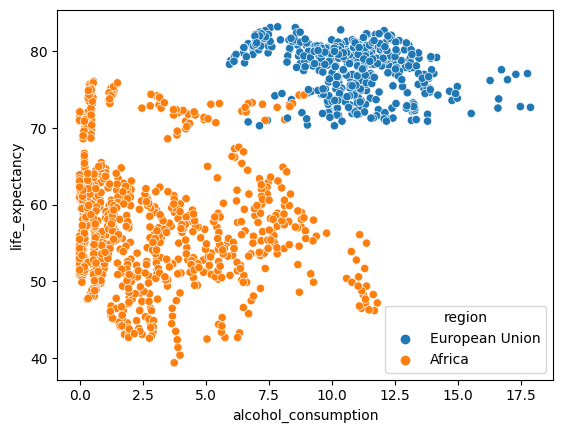

In [77]:
sns.scatterplot(x='alcohol_consumption', y='life_expectancy', data=europe_or_africa, hue='region')

Calculando a correlação entre as duas variáveis na União Europeia e na África:

In [78]:
eu = europe_or_africa[europe_or_africa['region'] == 'European Union']
af = europe_or_africa[europe_or_africa['region'] == 'Africa']

pearson_coef, p_value = stats.pearsonr(eu['alcohol_consumption'], eu['life_expectancy'])
print("Correlação de Pearson para Europa: ", pearson_coef, " | P-valor: ", p_value)

pearson_coef, p_value = stats.pearsonr(af['alcohol_consumption'], af['life_expectancy'])
print("Correlação de Pearson para Africa: ", pearson_coef, " | P-valor: ", p_value)

Correlação de Pearson para Europa:  -0.3176588365484485  | P-valor:  1.3881362131472913e-11
Correlação de Pearson para Africa:  -0.16229128542557025  | P-valor:  3.165400397964874e-06


As correlações entre as variáveis nos continentes são negativas, e também são mais fracas, indicando que o consumo de álcool não é um fator muito relevante para a expectativa de vida nesses continentes, contrariando a análise conjunta dos continentes. Dessa forma, podemos dizer que a região é um _fator de confusão_ para a correlação entre as variáveis.

# Teste de Hipótese: Diferença entre o crescimento da expectativa de vida de países desenvolvidos e não desenvolvidos

H0: o país ser desenvolvido ou não não afeta a média da diferença entre a expectativa de vida de 2015 e 2000

H1: países não desenvolvidos tiveram um aumento médio maior na expectativa de vida entre 2000 e 2015 em comparação com países desenvolvidos

In [79]:
# conta paises desenvolvidos
developed_countries = dataset[dataset['developed'] == True]
developed_countries['country'].nunique()

37

In [80]:
# diferença entre a expectativa de vida de 2015 e 2000
# novo dataset com os países e as diferenças
life_expectancy_difference = pd.DataFrame(columns=['country', 'difference', 'region', 'developed'])
life_expectancy_difference['country'] = dataset['country'].unique()

# calcula a diferença para cada país
for country in life_expectancy_difference['country']:
    difference = dataset[(dataset['country'] == country) & (dataset['year'] == 2015)]['life_expectancy'].values[0] - dataset[(dataset['country'] == country) & (dataset['year'] == 2000)]['life_expectancy'].values[0]
    life_expectancy_difference.loc[life_expectancy_difference['country'] == country, 'difference'] = difference
    life_expectancy_difference.loc[life_expectancy_difference['country'] == country, 'region'] = dataset[dataset['country'] == country]['region'].values[0]
    life_expectancy_difference.loc[life_expectancy_difference['country'] == country, 'developed'] = dataset[dataset['country'] == country]['developed'].values[0]

life_expectancy_difference

,country,difference,region,developed
0,Turkiye,6.5,Middle East,False
1,Spain,3.8,European Union,True
2,India,6.1,Asia,False
3,Guyana,4.1,South America,False
4,Israel,3.1,Middle East,True
...,...,...,...,...
174,Qatar,2.3,Middle East,False
175,Fiji,1.4,Oceania,False
176,Australia,3.2,Oceania,True
177,North Macedonia,2.5,Rest of Europe,False


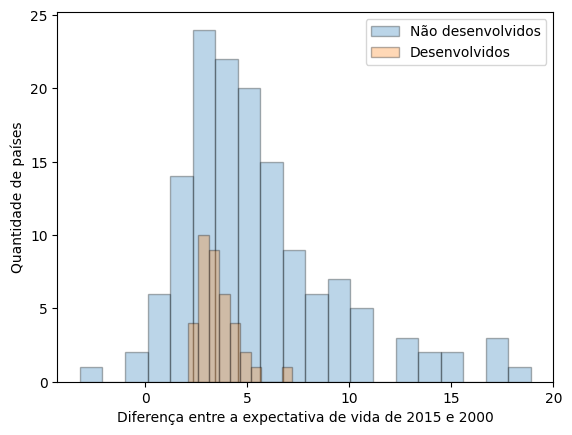

In [81]:
developed = life_expectancy_difference[life_expectancy_difference['developed'] == True]
not_developed = life_expectancy_difference[life_expectancy_difference['developed'] == False]


plt.hist(not_developed['difference'], bins=20, alpha=0.3, label='Não desenvolvidos', edgecolor='k')
plt.hist(developed['difference'], alpha=0.3, label='Desenvolvidos', edgecolor='k')
plt.xlabel('Diferença entre a expectativa de vida de 2015 e 2000')
plt.ylabel('Quantidade de países')
plt.legend()
plt.show()

In [82]:
# diferença de médias entre os países desenvolvidos e não desenvolvidos
developed = life_expectancy_difference[life_expectancy_difference['developed'] == True]
not_developed = life_expectancy_difference[life_expectancy_difference['developed'] == False]

developed_mean = developed['difference'].mean()
not_developed_mean = not_developed['difference'].mean()

print('Média de diferença entre a expectativa de vida de 2015 e 2000 para países desenvolvidos: ', developed_mean)
print('Média de diferença entre a expectativa de vida de 2015 e 2000 para países não desenvolvidos: ', not_developed_mean)

t_obs = not_developed_mean - developed_mean

print('Diferença entre as médias: ', t_obs)

Média de diferença entre a expectativa de vida de 2015 e 2000 para países desenvolvidos:  3.556756756756756
Média de diferença entre a expectativa de vida de 2015 e 2000 para países não desenvolvidos:  5.506338028169014
Diferença entre as médias:  1.9495812714122582


Testaremos se essa diferença foi devido ao acaso ou se é significativa, por meio do teste de permutação.

In [83]:
df_shuffled = life_expectancy_difference.copy()
filtro = df_shuffled['developed'] == False
np.random.shuffle(filtro.values)
diff = df_shuffled[filtro]['difference'].mean() - df_shuffled[~filtro]['difference'].mean()
diff

0.6924248191853817

Repetir o teste 10000 vezes:

In [84]:
N = 10000
diferencas = np.zeros(N)
for i in range(N):
    np.random.shuffle(filtro.values)
    diff = df_shuffled[~filtro]['difference'].mean() - df_shuffled[filtro]['difference'].mean()
    diferencas[i] = diff

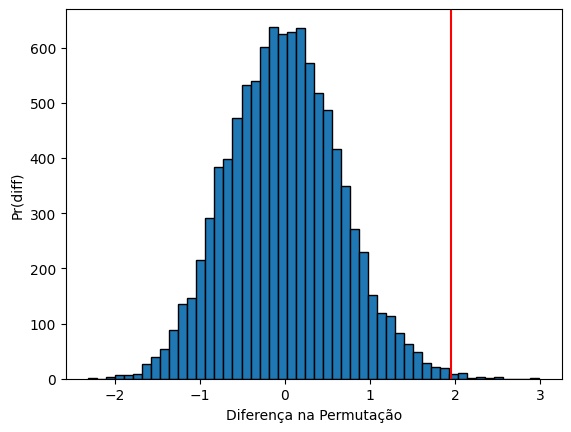

In [85]:
plt.hist(diferencas, bins=50, edgecolor='k')
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')
plt.vlines(t_obs, 0, 0.14, color='red')
plt.axvline(t_obs, color='red')
plt.show()

Cálculo do p-valor:

In [86]:
p_value = np.count_nonzero(diferencas > t_obs) / N
p_value

0.0028

#### CONCLUSÃO
Dado que o p-valor é menor que 0.05, podemos rejeitar a hipótese nula e concluir que a diferença entre a expectativa de vida de 2015 e 2000 foi significativamente maior em países não desenvolvidos.

## nao sei o nome, analises experimentais? guerras!!

In [87]:
#países em que a diferença de expectativa de vida é negativa
life_expectancy_difference[life_expectancy_difference['difference'] < 0]

,country,difference,region,developed
43,Grenada,-0.2,Central America and Caribbean,False
100,Syrian Arab Republic,-3.2,Middle East,False


Iremos focar na Síria, pela maior diferença.

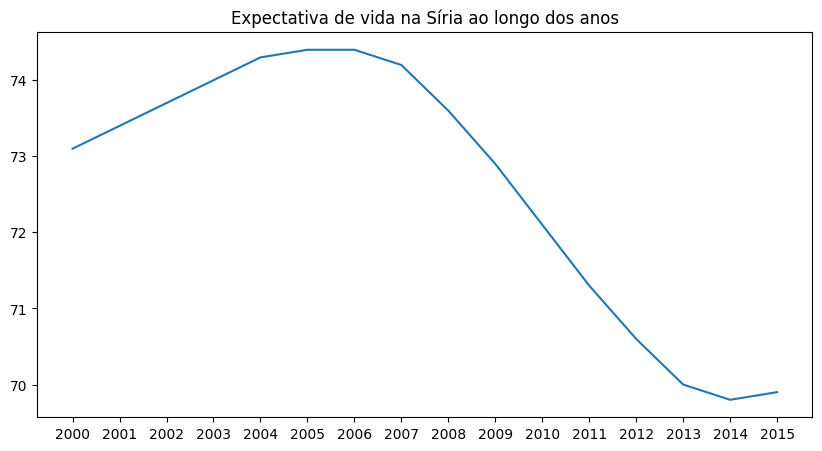

In [88]:
#gráfico de expectativa de vida ao longo dos anos
syria = dataset[dataset['country'] == 'Syrian Arab Republic']
syria = syria.sort_values(by='year')
syria[['year', 'life_expectancy']]
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Expectativa de vida na Síria ao longo dos anos')
plt.plot(syria['year'], syria['life_expectancy'])

In [89]:
#diferença entre a maior e a menor expectativa de vida da síria e anos em que ocorreram
maxYear = syria[syria['life_expectancy'] == syria['life_expectancy'].max()]['year']
minYear = syria[syria['life_expectancy'] == syria['life_expectancy'].min()]['year']
max = syria['life_expectancy'].max()
min = syria['life_expectancy'].min()
print('Ano com maior expectativa de vida: ', maxYear.values[0], ' | Expectativa de vida: ', max)
print('Ano com menor expectativa de vida: ', minYear.values[0], ' | Expectativa de vida: ', min)
print('Diferença: ', max - min)

Ano com maior expectativa de vida:  2005  | Expectativa de vida:  74.4
Ano com menor expectativa de vida:  2014  | Expectativa de vida:  69.8
Diferença:  4.6000000000000085


A Síria é palco de uma guerra civil que começou em 2011 e ainda não acabou. A guerra civil na Síria é um conflito entre o governo sírio e forças da oposição, que começou com protestos pacíficos contra o governo sírio, liderado pelo presidente Bashar al-Assad. O conflito se transformou em uma guerra civil, após o uso da força pelo governo para reprimir os protestos.

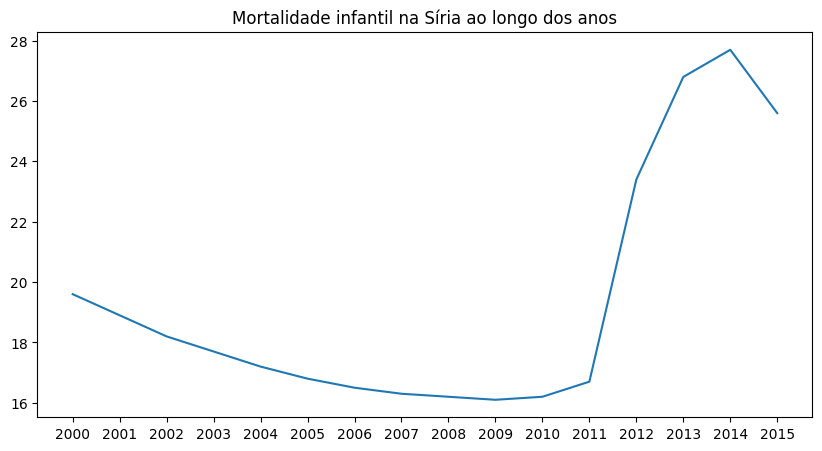

In [90]:
#mortalidade infantil ao longo dos anos

plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade infantil na Síria ao longo dos anos')
plt.plot(syria['year'], syria['infant_deaths'])

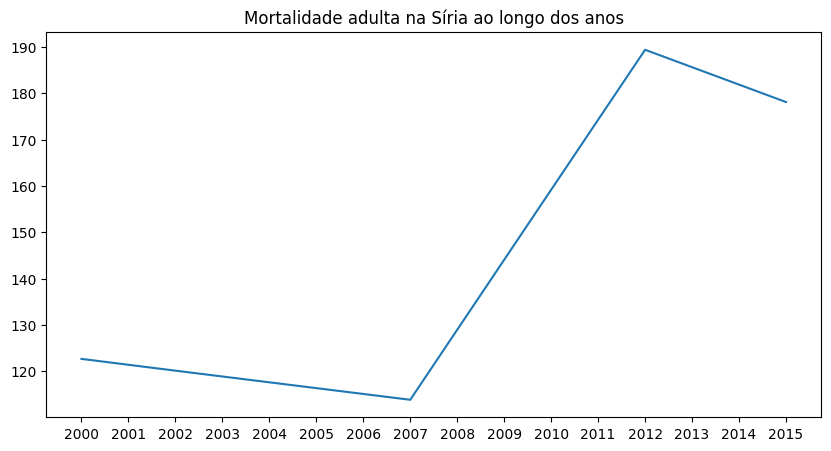

In [91]:
#mortalidade adulta ao longo dos anos
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade adulta na Síria ao longo dos anos')
plt.plot(syria['year'], syria['adult_mortality'])

No dataset utilizado, o número de mortes infantis e adultas é em cada 1000 habitantes
Infantil de 17 para 28
Adulta 115 para 19, 75, muito
ESCREVER CONCLUSÃO DEPOIS

##### AFEGANISTÃO

acho que não consta colocar, nada fora do normal

#### IRAQUE

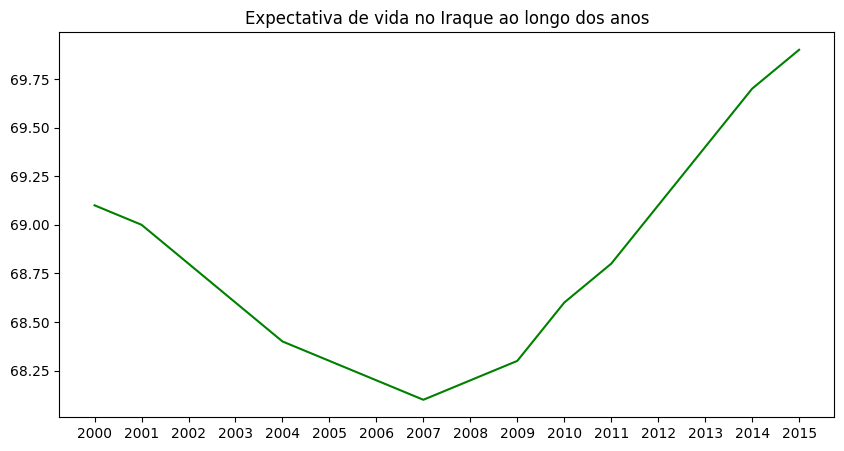

In [92]:
#gráfico de expectativa de vida ao longo dos anos
iraq = dataset[dataset['country'] == 'Iraq']
iraq = iraq.sort_values(by='year')
iraq[['year', 'life_expectancy']]
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Expectativa de vida no Iraque ao longo dos anos')
plt.plot(iraq['year'], iraq['life_expectancy'], color = 'green')

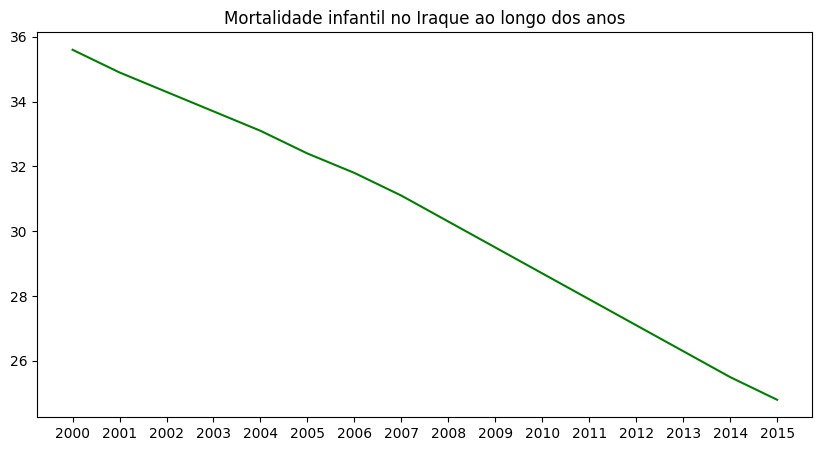

In [93]:
#mortalidade infantil ao longo dos anos
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade infantil no Iraque ao longo dos anos')
plt.plot(iraq['year'], iraq['infant_deaths'], color = 'green')


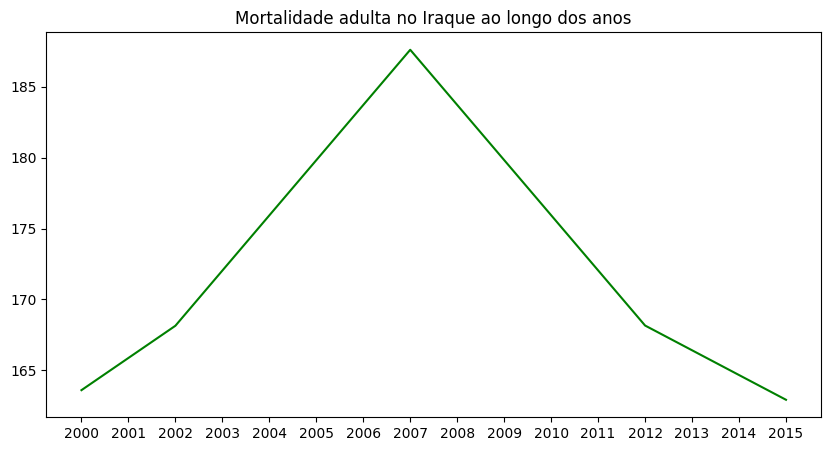

In [94]:
#mortalidade adulta ao longo dos anos
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade adulta no Iraque ao longo dos anos')
plt.plot(iraq['year'], iraq['adult_mortality'], color = 'green')


14 de Agosto de 2007 ocorreu o ataque mais mortífero desde o início da guerra. Mais de 500 civis foram mortos numa série de ataques bombistas suicidas coordenados no norte do Iraque em Qahtaniya. Mais de 100 casas e lojas foram destruídas nas explosões. Mesmo assim diferença de 20 a cada 1000 adultos, não tao impactante

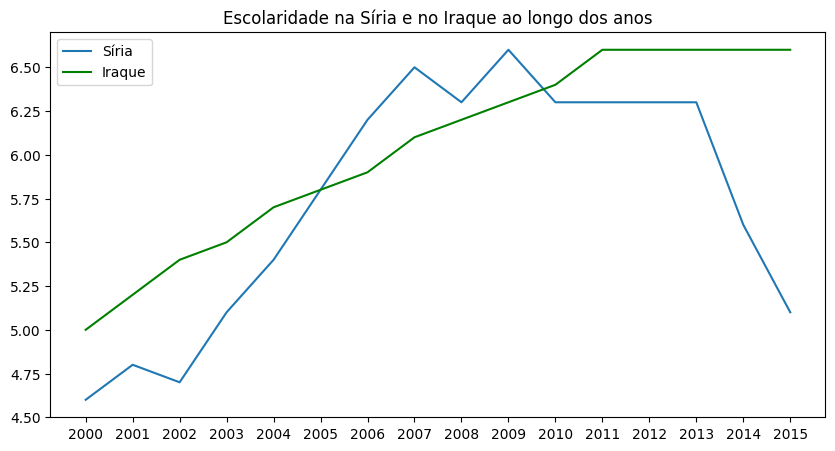

In [95]:
# grafico de schooling ao longo dos anos para a síria e o iraque
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Escolaridade na Síria e no Iraque ao longo dos anos')
plt.plot(syria['year'], syria['schooling'])
plt.plot(iraq['year'], iraq['schooling'], color = 'green')
plt.legend(['Síria', 'Iraque'])

conclusão geral: guerra da siria afetou mais crianças que iraque? morte e escolaridade

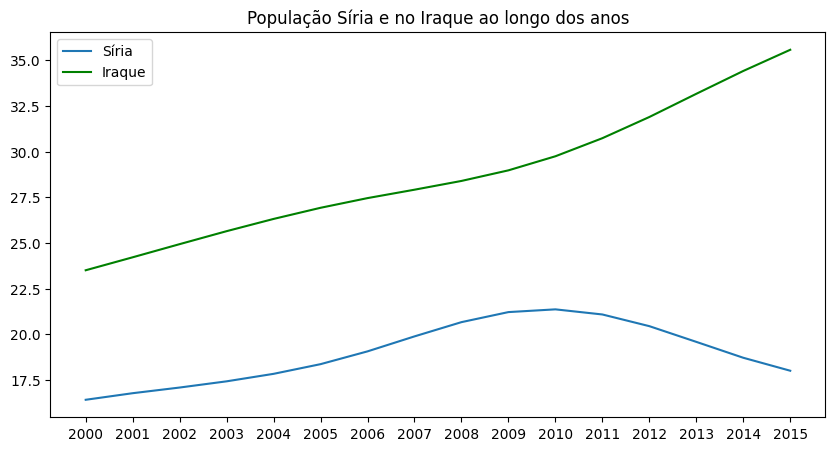

In [96]:
#grafico de populacao ao longo dos anos para a síria e o iraque
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('População Síria e no Iraque ao longo dos anos')
plt.plot(syria['year'], syria['population_mln'])
plt.plot(iraq['year'], iraq['population_mln'], color = 'green')
plt.legend(['Síria', 'Iraque'])

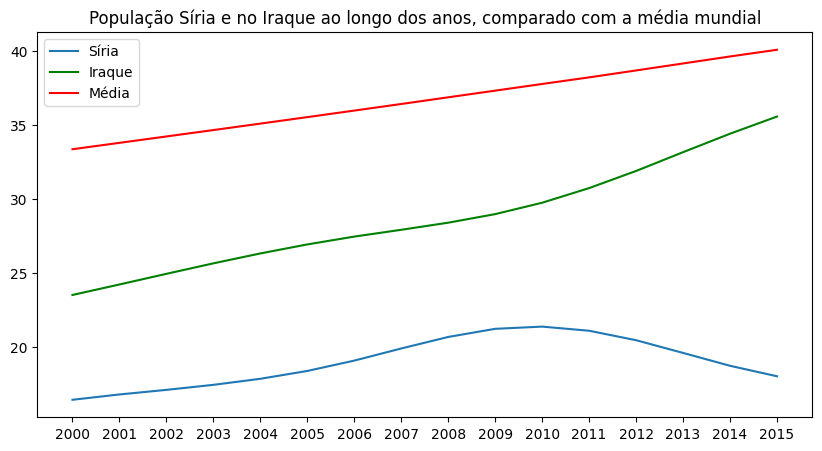

In [97]:
#media da populacao  todos/quantidade de paises por ano
media_populacao = dataset.groupby('year')['population_mln'].mean()

plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('População Síria e no Iraque ao longo dos anos, comparado com a média mundial')
plt.plot(syria['year'], syria['population_mln'])
plt.plot(iraq['year'], iraq['population_mln'], color = 'green')
plt.plot(media_populacao, color = 'red')
plt.legend(['Síria', 'Iraque', 'Média'])

iraque se recompos bem pos guerra? taxa de crescimento maior que a media mundial


### AFRICA

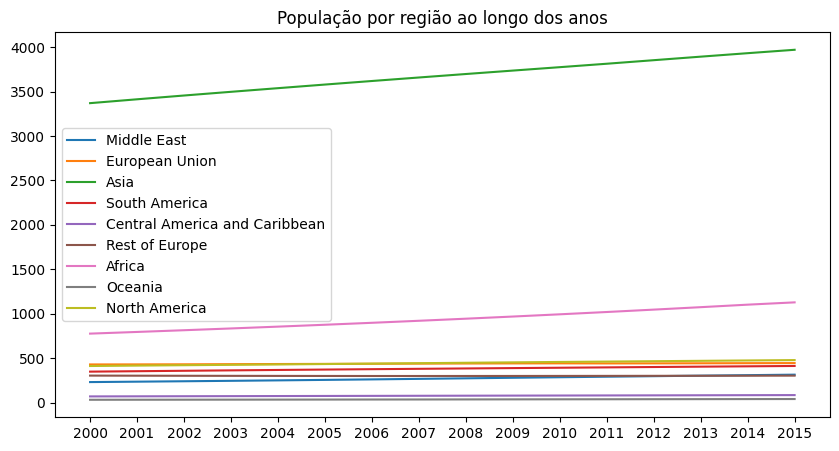

In [98]:
##população de cada region ao longo dos anos
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('População por região ao longo dos anos')
#region unique
region_unique = dataset['region'].unique()
for region in region_unique:
    region_pop = dataset[dataset['region'] == region]
    region_pop = region_pop.groupby('year')['population_mln'].sum()
    plt.plot(region_pop)
plt.legend(region_unique)




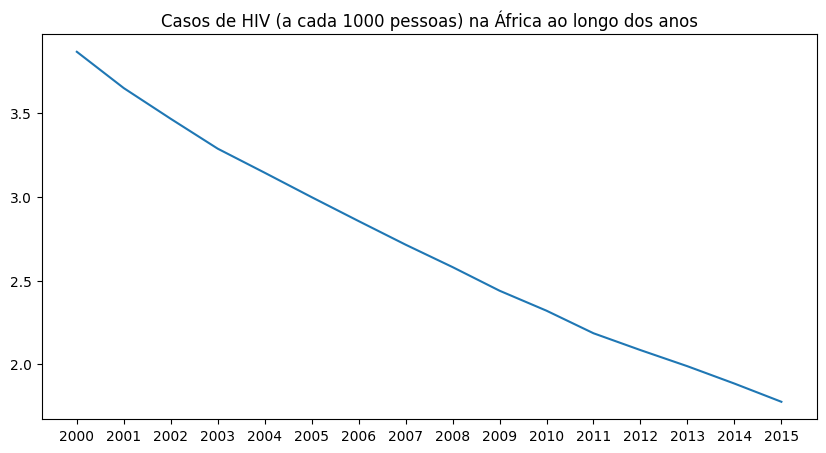

In [99]:
## hiv africa ao longo dos anos media dos paises
africa = dataset[dataset['region'] == 'Africa']
africa = africa.groupby('year')['incidents_hiv'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Casos de HIV (a cada 1000 pessoas) na África ao longo dos anos')
plt.plot(africa)

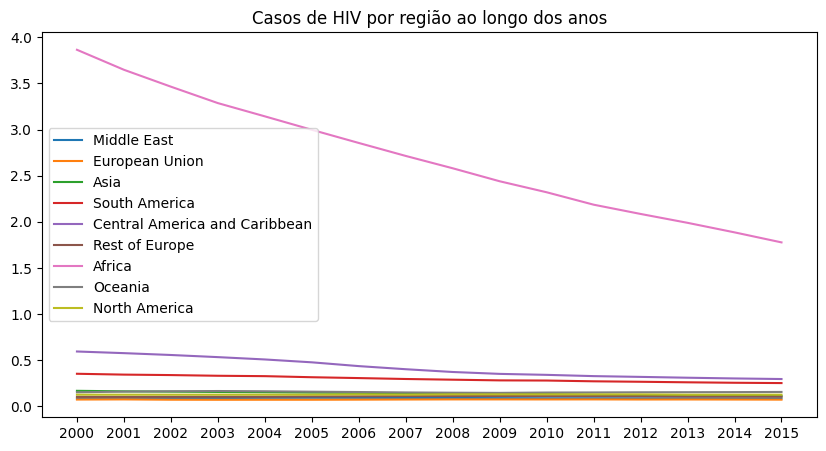

In [100]:
##hiv por regiao ao longo dos anos
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Casos de HIV por região ao longo dos anos')
#region unique
region_unique = dataset['region'].unique()
for region in region_unique:
    region_hiv = dataset[dataset['region'] == region]
    region_hiv = region_hiv.groupby('year')['incidents_hiv'].mean()
    plt.plot(region_hiv)
plt.legend(region_unique)


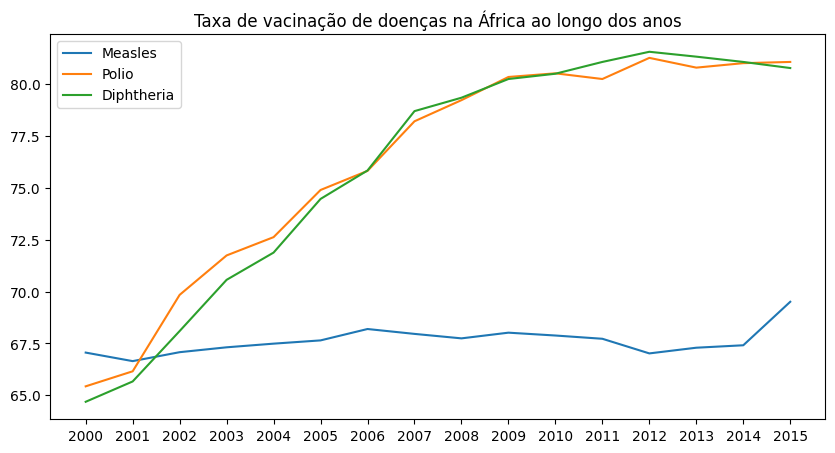

In [101]:
#taxa de cobertura de vacinação em bebes de 1 ano de doenças na africa ao longo dos anos
africa = dataset[dataset['region'] == 'Africa']
measles = africa.groupby('year')['measles'].mean()
polio = africa.groupby('year')['polio'].mean()
diphtheria = africa.groupby('year')['diphtheria'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Taxa de vacinação de doenças na África ao longo dos anos')
plt.plot(measles)
plt.plot(polio)
plt.plot(diphtheria)
plt.legend(['Measles', 'Polio', 'Diphtheria'])

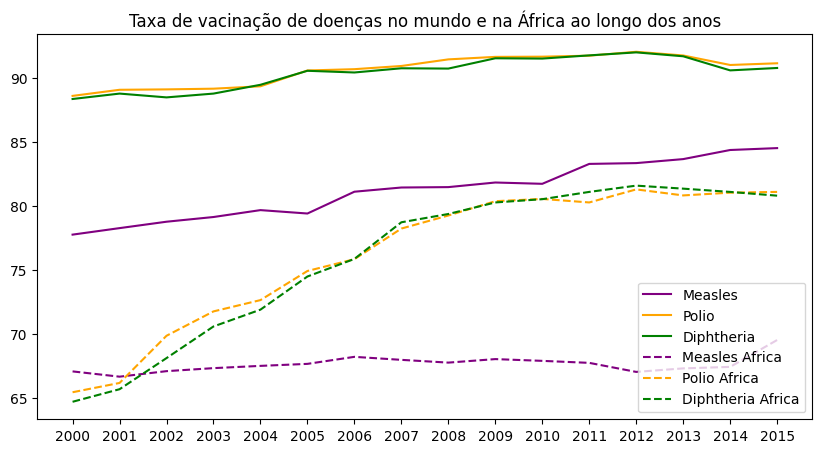

In [102]:
# tres graficos, um pra measles um pra polio e um pra diphtheria, com a media de cada doença por ano no mundo, sem a africa e na africa

resto_do_mundo = dataset[dataset['region'] != 'Africa']
measles = resto_do_mundo.groupby('year')['measles'].mean()
polio = resto_do_mundo.groupby('year')['polio'].mean()
diphtheria = resto_do_mundo.groupby('year')['diphtheria'].mean()
africa = dataset[dataset['region'] == 'Africa']
africa_measles = africa.groupby('year')['measles'].mean()
africa_polio = africa.groupby('year')['polio'].mean()
africa_diphtheria = africa.groupby('year')['diphtheria'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Taxa de vacinação de doenças no mundo e na África ao longo dos anos')
plt.plot(measles, color = 'purple')
plt.plot(polio, color = 'orange')
plt.plot(diphtheria, color = 'green')
plt.plot(africa_measles, linestyle='dashed', color = 'purple')
plt.plot(africa_polio, linestyle='dashed', color = 'orange')
plt.plot(africa_diphtheria, linestyle='dashed', color = 'green')
plt.legend(['Measles', 'Polio', 'Diphtheria', 'Measles Africa', 'Polio Africa', 'Diphtheria Africa'])

é possivel observar que a taxa de vacinação na africa é consideravelmente menor que a media mundial, porem, para Polio e Diphtheria, a taxa de o africana apresenta um aumento muito significativo, concluir!!! (pode ter influenciado na diminuicao da taxa de mortalidade?)

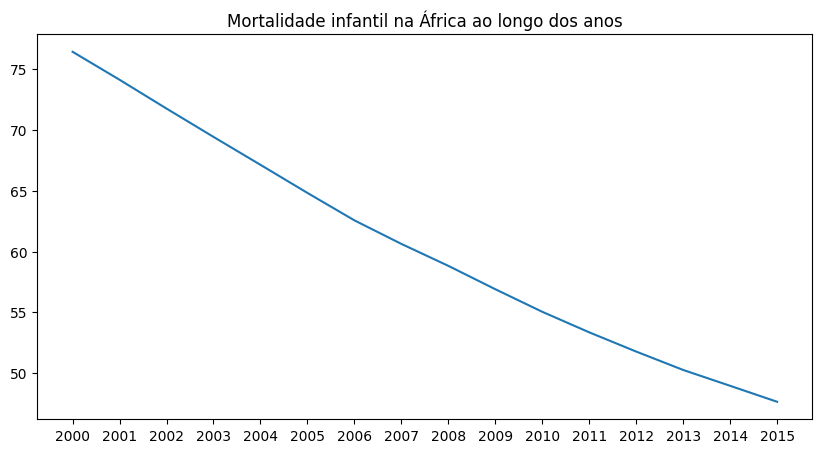

In [103]:
# mortalidade infantil africa ao longo dos anos media dos paises
africa = dataset[dataset['region'] == 'Africa']
africa = africa.groupby('year')['infant_deaths'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade infantil na África ao longo dos anos')
plt.plot(africa)

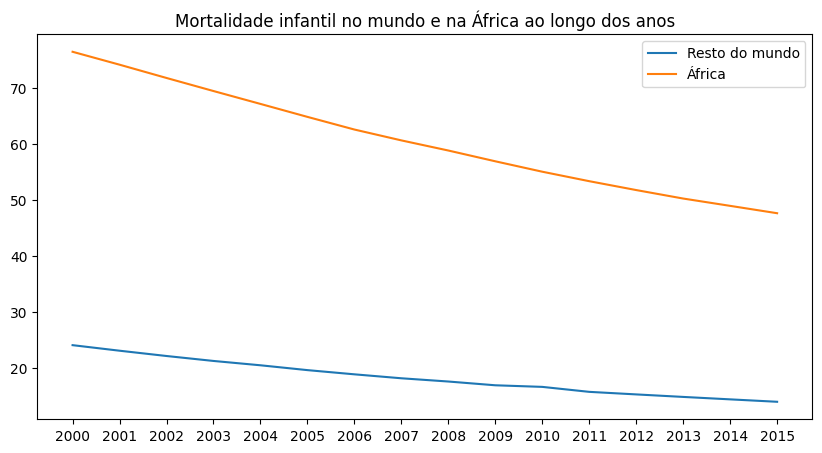

In [104]:
# mortalidade infantil mundial sem a africa uma linha para a africa
resto_do_mundo = dataset[dataset['region'] != 'Africa']
resto_do_mundo = resto_do_mundo.groupby('year')['infant_deaths'].mean()
africa = dataset[dataset['region'] == 'Africa']
africa = africa.groupby('year')['infant_deaths'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade infantil no mundo e na África ao longo dos anos')
plt.plot(resto_do_mundo)
plt.plot(africa)
plt.legend(['Resto do mundo', 'África'])

taxa de diminuicao africana muito maior que o resto do mundo, mas ainda numero de mortes extremamente maior 

interligando com a mortalidade infantil durante guerras


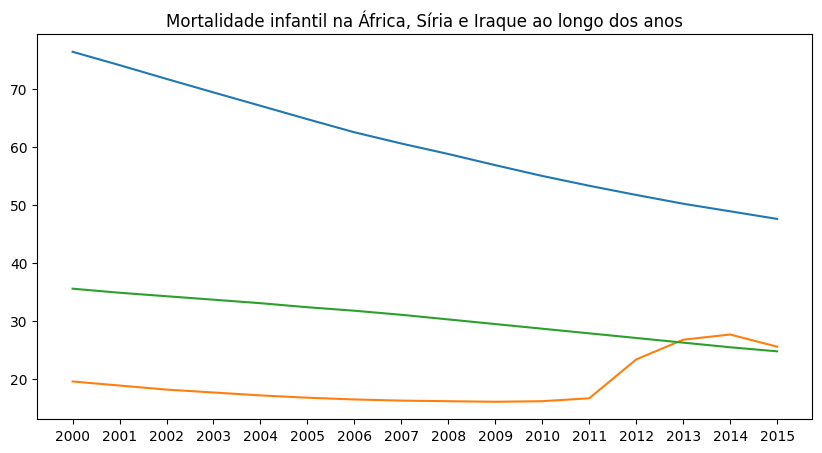

In [105]:
#africa, siria e iraque, media de mortes infantis por ano
africa = dataset[dataset['region'] == 'Africa']
africa = africa.groupby('year')['infant_deaths'].mean()
syria = dataset[dataset['country'] == 'Syrian Arab Republic']
syria = syria.groupby('year')['infant_deaths'].mean()
iraq = dataset[dataset['country'] == 'Iraq']
iraq = iraq.groupby('year')['infant_deaths'].mean()
plt.figure(figsize=(10, 5))
plt.xticks(np.arange(2000, 2016, 1.0))
plt.title('Mortalidade infantil na África, Síria e Iraque ao longo dos anos')
plt.plot(africa)
plt.plot(syria)
plt.plot(iraq)

# Regressão Linear Simples

Text(0.5, 0, 'life_expectancy')

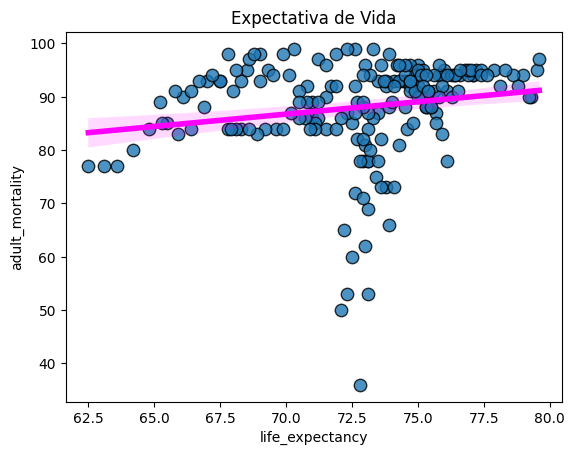

In [122]:
sth_amr = dataset[dataset['region'] == 'South America']

sns.regplot(x='life_expectancy', y='adult_mortality', data=sth_amr, n_boot=10000,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
plt.title('Expectativa de Vida')
plt.ylabel("adult_mortality")
plt.xlabel("life_expectancy")

In [107]:
# correlacao de pearson 
sth_amr = dataset[dataset['region'] == 'South America']
sth_amr = sth_amr[['life_expectancy', 'adult_mortality']]
sth_amr.corr(method='pearson')

,life_expectancy,adult_mortality
life_expectancy,1.0000,-0.9693
adult_mortality,-0.9693,1.0000


In [108]:
model = ss.linregress(sth_amr['adult_mortality'], sth_amr['life_expectancy'])
# beta = slope
# alpha = intercept
model 

LinregressResult(slope=-0.09420803343205529, intercept=87.40891222450661, rvalue=-0.9692999228312235, pvalue=1.0310142326921417e-117, stderr=0.0017337186658206026, intercept_stderr=0.2764921787778366)

In [109]:
beta = model.slope
alpha = model.intercept
new_adult_mort = 40
life_exp = beta * new_adult_mort + alpha
life_exp

83.64059088722439

In [112]:
df = pd.read_csv('https://raw.githubusercontent.com/icd-ufmg/material/master/aulas/19-Multipla/aptosBH.txt', index_col=0)
df.describe()

,area,quartos,suites,vagas,preco
count,216.000000,216.000000,216.000000,216.000000,2.160000e+02
mean,123.865324,3.050926,1.023148,1.958333,6.384766e+05
std,59.326378,0.748455,0.514371,0.736507,3.019863e+05
min,26.000000,2.000000,0.000000,0.000000,2.500000e+05
25%,81.690000,2.750000,1.000000,2.000000,4.560000e+05
50%,102.595000,3.000000,1.000000,2.000000,5.500000e+05
75%,154.167500,4.000000,1.000000,2.000000,7.500000e+05
max,400.000000,5.000000,4.000000,4.000000,2.025000e+06


In [113]:
sth_amr.describe()

,life_expectancy,adult_mortality
count,192.000000,192.000000
mean,72.780729,155.275326
std,3.544688,36.471045
min,62.500000,88.866500
25%,70.800000,129.253875
50%,73.200000,149.890750
75%,75.300000,174.416375
max,79.600000,240.046500


In [119]:
# correlacao de pearson
area, preco = df['suites'], df['preco']
area.corr(preco, method='pearson')

0.46934734356327523

In [121]:
sth_amr = dataset[dataset['region'] == 'South America']
sth_amr = sth_amr[['life_expectancy', 'hepatitis_b']]
sth_amr.corr(method='pearson')

,life_expectancy,hepatitis_b
life_expectancy,1.000000,0.175443
hepatitis_b,0.175443,1.000000
